# Lesson Preview 
State-of-the-art RL algorithm contain many important tweaks in addition to simple value-based or policy-based methods. One of these key improvements is called Proximal Policy Optimization(PPO) -- also closely related to Trust Region Policy Optimization (TRPO). It has allowed faster and more stable learning. For developing agile robots, to creating expert level gaming AI, PPO has proven useful in a wide domain of applications, and has become part of the standard toolkits in complicated learning environments.

In this lesson, we will first review the most basic policy gradient algorithm -- REINFORCE, and discuss issues associated with the algorithm. We will get an in-depth understanding of why these problem arise, and find ways to fix them. The solutions will lead us to PPO. Our lesson will focus learning the intutions behind why and how PPO improves learning, and implement it to teach a computer to play Atari-Pong, using only the pixels as input.

*The idea of PPO was published by the team at OpenAI!*

# Beyond REINFORCE

Here, we briefly review key ingredients of the REINFORCE algorithm.

REINFORCE works as follows: First, we initialize a random policy $\pi_\theta(a;s)$, and using the policy we collect a trajectory -- or a list of (state, actions, rewards) at each time step:
<br>$s_1,a_1,r_1,s_2,a_2,r_2,...$

Secondly, we compute the total reward of trajectory $R = r_1+r_2+r_3+...$ and compute the estimate the gradient of the expected reward, g:
<br> $g = R\sum_t \delta_{\theta}\log\pi_\theta(a_t|s_t)$


Third, we update our policy using gradient ascent with learning rate $\alpha$:
<br>$\theta \gets \theta + \alpha g$

The process repeats.

* What are the main problems of REINFORCE? There are three issues:
    1. The update process is very **inefficient**! We run the policy once, update once, and throw away the trajectory.
    2. The gradient estimate g is very **noisy**. By chance the collected trajectory may not be representative of the policy.
    3. There is no clear **credit assignment**. A trajectory may contain many good/bad actions and whether these actions are reinforced depends only on the final total output.

# Noise Reduction
The way we optimize the policy is by maximizing the average reward $U(\theta)$. To do that we use stochastic gradient ascent. Mathematically, the **gradient is given by an average over all the  possible TRAJECTORIES,**
<br>$\delta_\theta U(\theta) = \sum_{\tau}P(\tau;\theta)[R\sum_t \delta_{\theta}\log\pi_\theta(a_t|s_t)]$

There could be easily be well over millions of trajectories for simple problems, and infinite for continuous problems.

For practical purposes, we simply take one trajectory to compute the gradient, and update our policy. So a lot of times, the result of a sampled trajectory comes down to **chance**, and doesn't contain that much information about our policy. How does learning happen then? __The hope is that after training for a long time, the tiny signal accumulates.__

The easiest option to reduce the noise in the gradient is to simply sample **more** trajectories! Using **distributed** computing, we can collect multiple trajectories in parallel, so that it won't take too much time. Then we can estimate the policy gradient by averaging across all the different trajectories.
<br>$g = \frac{1}{N}\sum_{i=1}^{N}R_i\sum_{t} \delta_{\theta}\log(\pi_\theta(a_t^{(i)}|s_t^{(i)}))$


## Rewards Normalization
__There is another bonus for running multiple trajectories: we can collect all the total rewards and get a sense of how they are distributed.__

In many cases, the distribution of rewards shifts as learning happens, Reward=1 might be really good in the beginning, but really bad after 1000 training episode.

Learning can be improved if we normalize the rewards, where $\mu$ is the mean, and $\sigma$ the standard deviation.
   - $R_i \gets \frac{R_i - \mu}{\sigma}$
   - $\mu = \frac{1}{N}\sum^{N}_i R_{i}$
   - $\sigma =\sqrt{\frac{1}{N}\sum_{i}(R_i-\mu)^2} $
   - *when all the $R_i$ are the same, $\sigma=0$, we set all normalized rewards to o to avoid numerical problems*
   
  
The batch-normalization technique is also used in many other problem in AI (e.g. images classification), where normalizing the input can improve learning.

Intuitvely, normalizing the rewards roughly corresponds to picking half action to encourage/discourage, while also making sure the steps for gradient ascents are not too large/small.

# Credit Assignment 
Going back to the gradient estimate, we can take a closer look at the total reward $R$, which is just a sum of reward of each step $R = r_1 + r_2 + r_3 + .... + r_{t-1}+r_t + ...$
<br>$g = \sum_t (... + r_{t-1}+r_t+ ...)\delta_{\theta}\log\pi_\theta(a_t|s_t)$

Let's think about what happens at time step $t$. Even before an action is decided, the agent has already received all the reward as the reward from the past. The rest is denoted as the future reward.


Because we have a __Markov process__, the action at time-step $t$ can only affect the __future reward__, so the past reward shouldn't be contributing to the policy gradient. So to properly assign credit to the action $a_t$, we should ignore the past reward.So a better policy gradient would simply have the future reward as the coefficient.
<br>$g = \sum_{t}R_t^{future}\delta_{\theta}\log\pi_\theta(a_t|s_t)$

## Note on Gradient Modification
We might wonder, why is it okay to change our gradient? Wouldn't that change our original goal of maximizing the expected reward?

It turns out that mathematically, ignoring past rewards might change the gradient for each specific trajectory, but it doesn't change the **Averaged** gradient. So even though the gradient is different during training, on average we are still maximizing the average reward. In fact, the resultant gradient is less noisy, so training using future reward should speed things up!

# pong with REINFORCE

## Important Packages

In [13]:
# install package for display animation
#!pip install JSAnimation

## custom utilities for displaying animation, collecting and rollouts
## and more 
import pong_utils
import torch
import numpy as np
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display
import random as rand



In [14]:
## render ai gym environment 
import gym
import time

#PongDeterministic does not contain random frameskip
# so is faster to train than the vanilla Pong-v4 environment 
env = gym.make('PongDeterministic-v4')

print("List of available actions: ", env.unwrapped.get_action_meanings())

# We will only use the action 'RIGHTFIRE = 4' and 'LEFTFIRE ' =5
# the 'FIRE' part ensures that the game start again after losing a life 
# the actions are hard-coded in pong_utils.py

List of available actions:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


# Preprocessing 
To speed up training, we can simplify the input by cropping the images and use every other pixels.

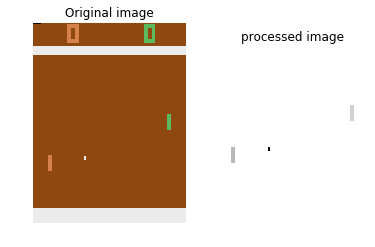

(80, 80)


In [15]:
import matplotlib
import matplotlib.pyplot as plt

#show what a preprocessed images looks like
env.reset()
temp= env.step(0)

## get a frame after 20 steps
for _ in range(20):
    frame,_,_,_ = env.step(1)
    
plt.subplot(1,2,1)
plt.imshow(frame)
plt.axis('off')
plt.title("Original image")

plt.subplot(1,2,2)
plt.title('processed image')
plt.axis('off')

#80x80 black and white image
plt.imshow(pong_utils.preprocess_single(frame),cmap='Greys')
plt.show()
print(pong_utils.preprocess_single(frame).shape)

## Policy

# Exercise 1: Implementation of our Policy

Here, we define our policy. The input is the stack of two different frames(which captures the movement), and the output is a number $P_{right}$, the probability of moving left. Note that $P_{left}\ = \ 1 - P_{right}$

In [16]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# def get_cov_outdim(in_size,k_size,stride,padding=0):
#         return (in_size-k_size+2*padding)//stride +1
# def get_cov_outdim(in_size,k_size,stride,padding=0):
#         out = (in_size-k_size+2*padding)//stride +1
#         print(out)
#         return out

#set up a convolution neural network
# the output is the probability of moving right
class Policy(nn.Module):
    
    def __init__(self):
        super().__init__()
        ## input_size of the image is (80x80)
        self.conv1 = nn.Conv2d(2,32,kernel_size=4,stride=2)
        out_dim = self.get_cov_outdim(80,4,2)
        self.conv2 = nn.Conv2d(32,64,kernel_size=4,stride=2)
        out_dim = self.get_cov_outdim(out_dim,4,2)
        self.conv3 = nn.Conv2d(64,128,kernel_size=4,stride=4)
        out_dim  = self.get_cov_outdim(out_dim,4,4)
        self.size  = out_dim*out_dim*128
        
        ## 2 fully connected layer
        self.fc1 = nn.Linear(self.size,16)
        self.fc2 = nn.Linear(16,1)
        self.sig = nn.Sigmoid()
        
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc1(x.view(-1,self.size)))
        return self.sig(self.fc2(x))
    
    def get_cov_outdim(self,in_size,k_sizes,stride,padding=0):
        out = (in_size-k_sizes+(2*padding))//stride +1
#         print(out)
        return out
    
    
policy = Policy().to(device)
# we use the adam optimizer with learning rate 2e-4
# optim.SGD is also possible
import torch.optim as optim
optimizer = optim.Adam(policy.parameters(), lr = 1e-4)

cpu


# Game visualization

`pong_utils` contain a play function given the environment and a policy. An optional preprocess function can be supplied. Here we define a function that plays a game and show learning progress.




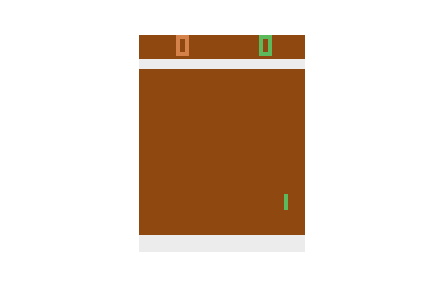
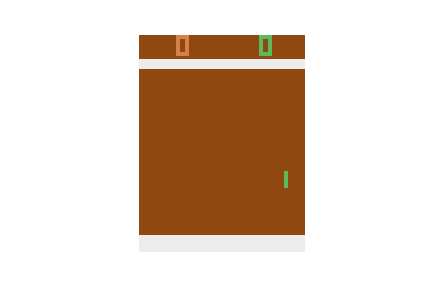
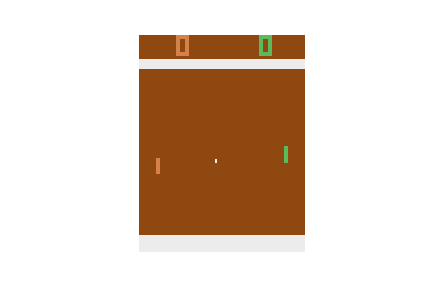
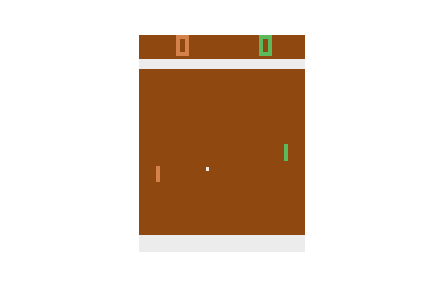
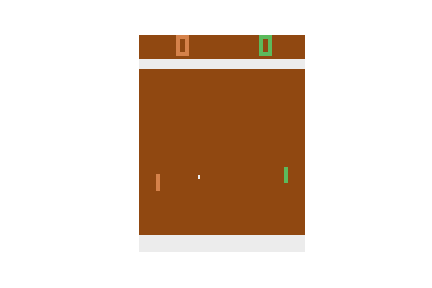
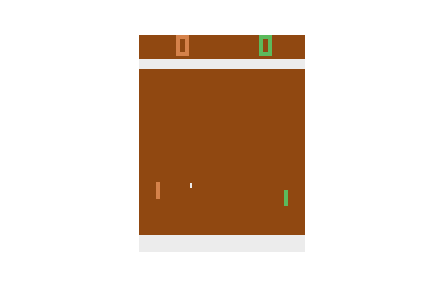
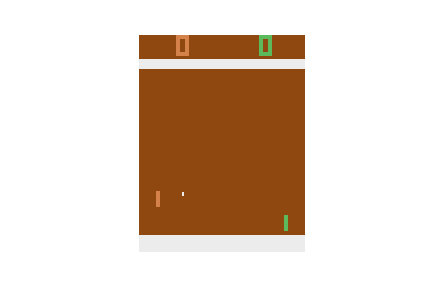
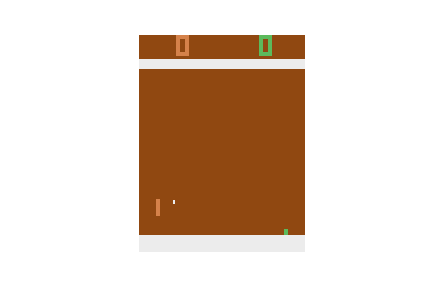
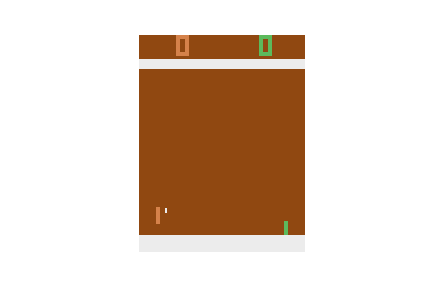
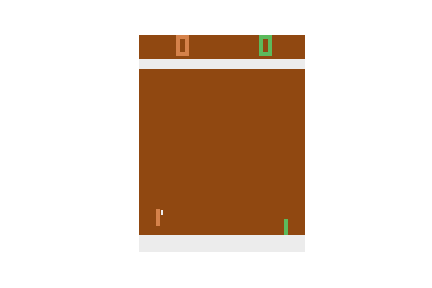
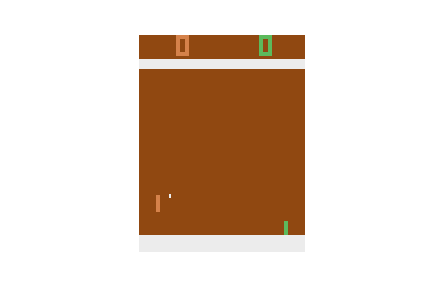
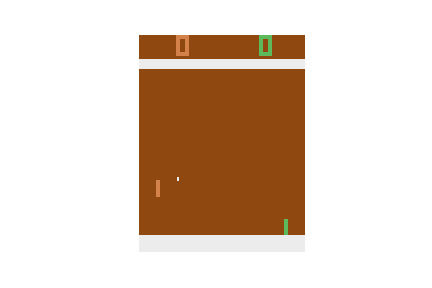
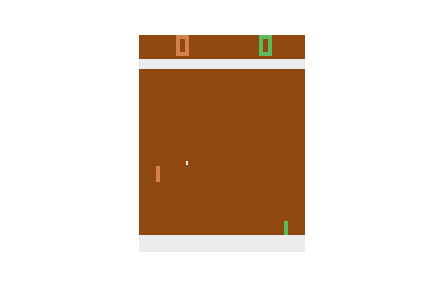
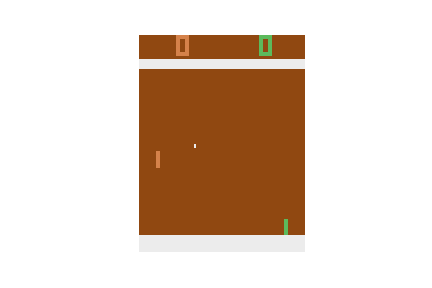
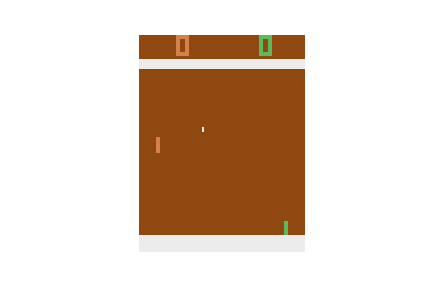
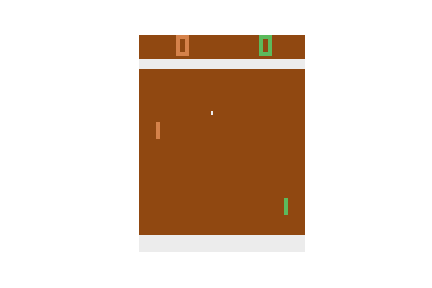
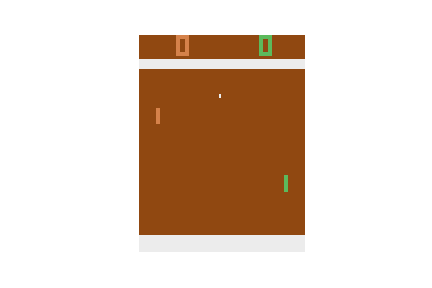
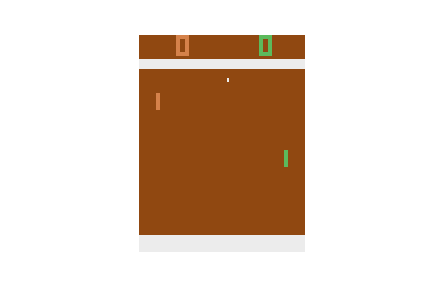
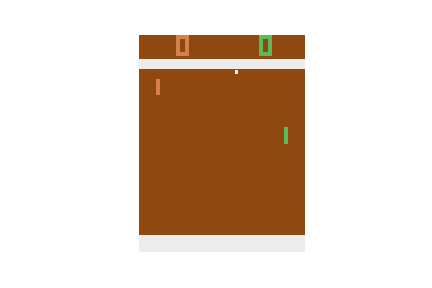
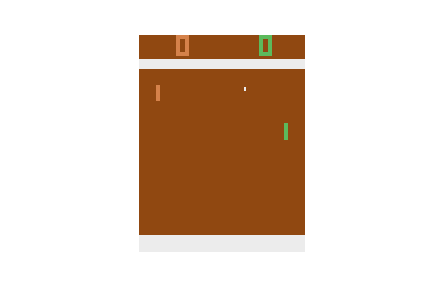
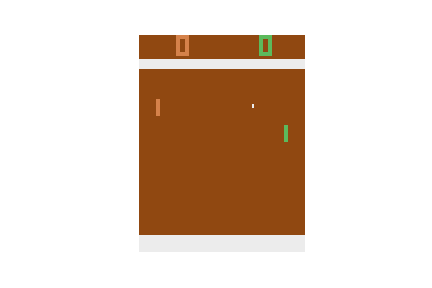
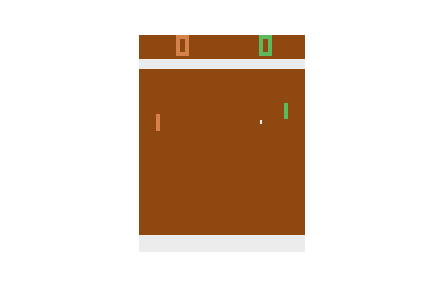
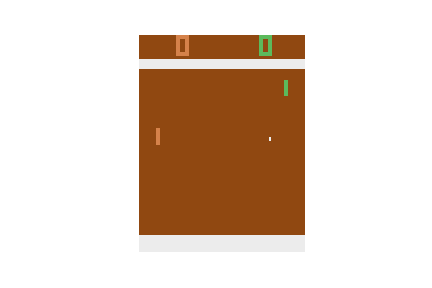
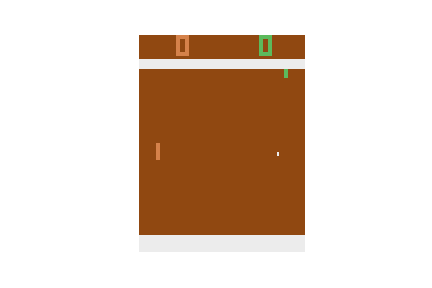
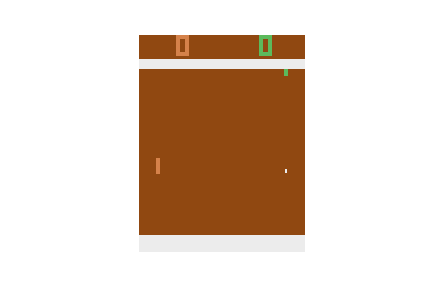
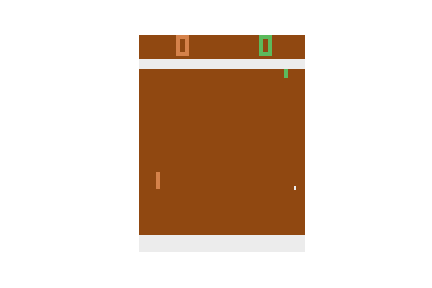
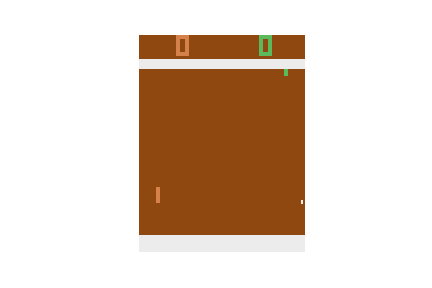
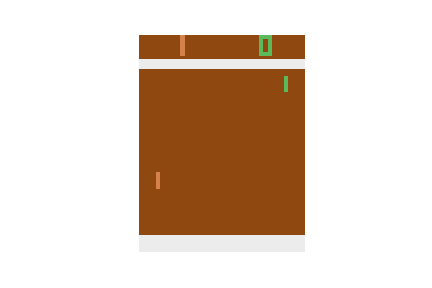
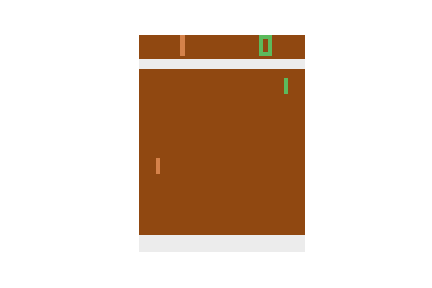
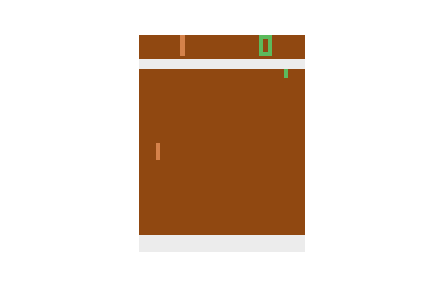
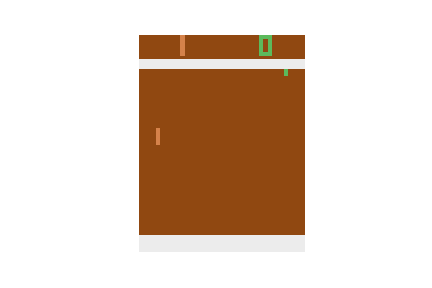
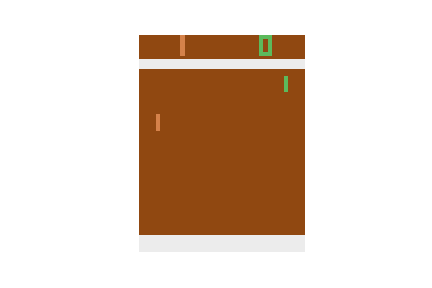
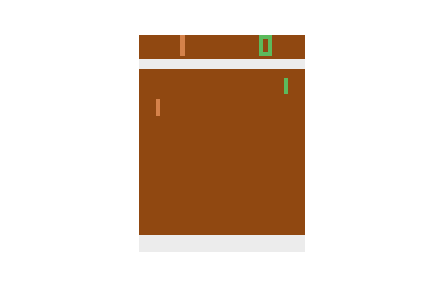
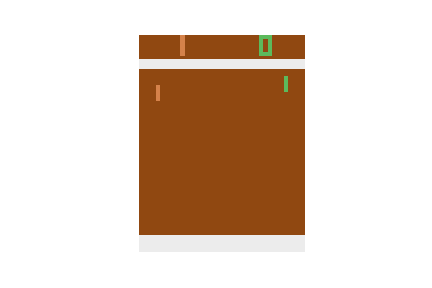
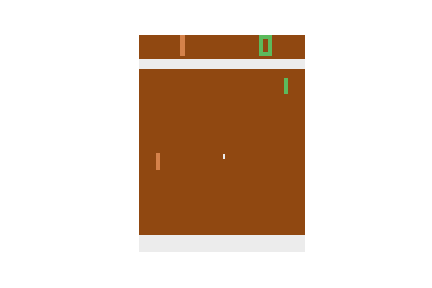
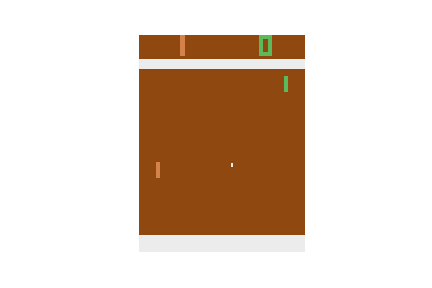
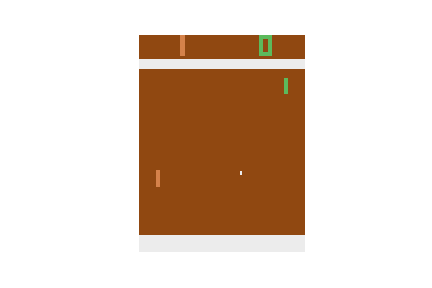
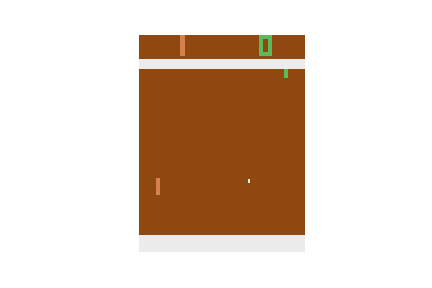
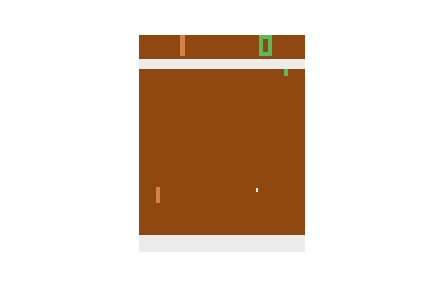
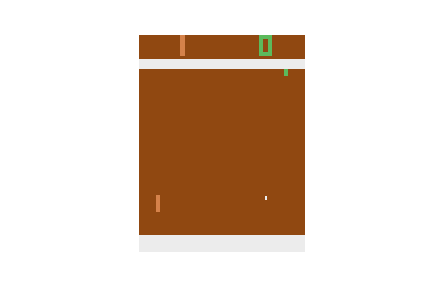
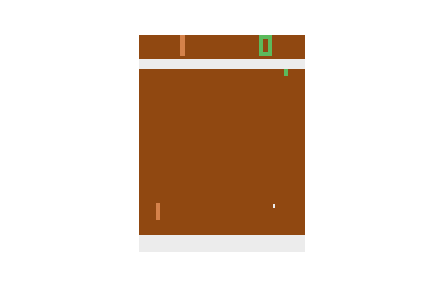
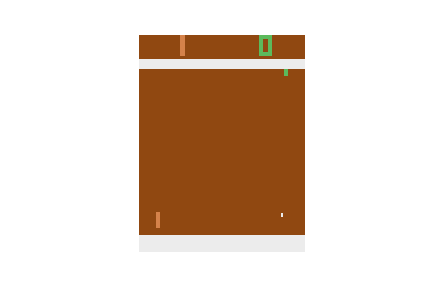
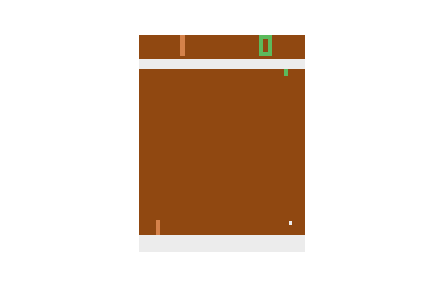
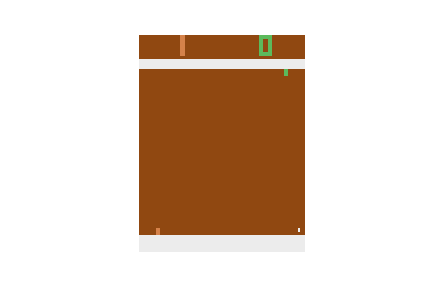
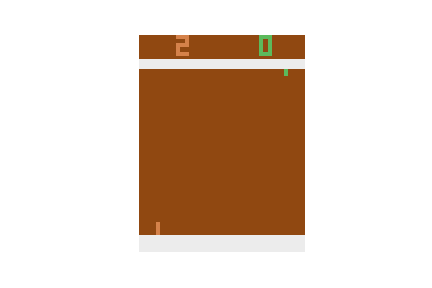
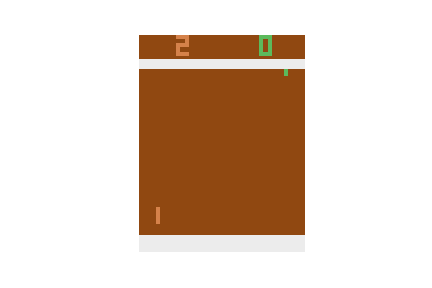
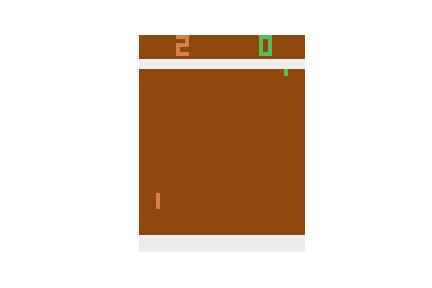
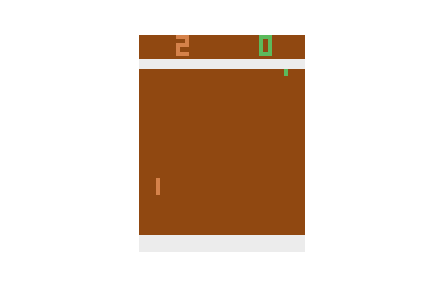
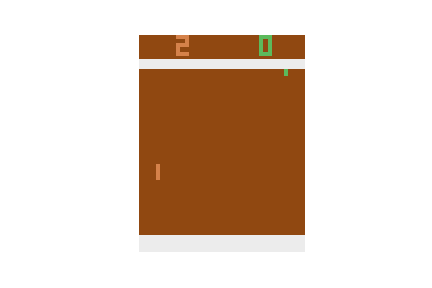
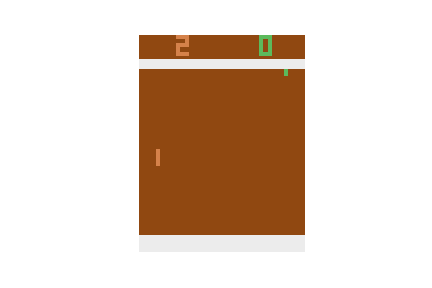
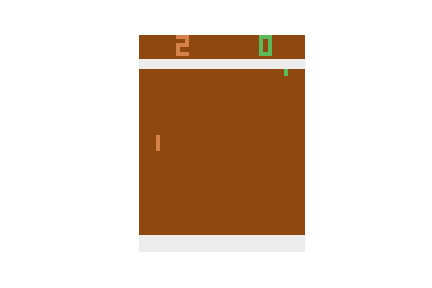
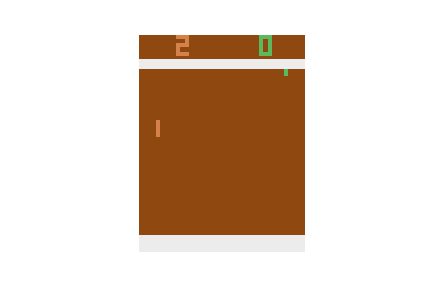
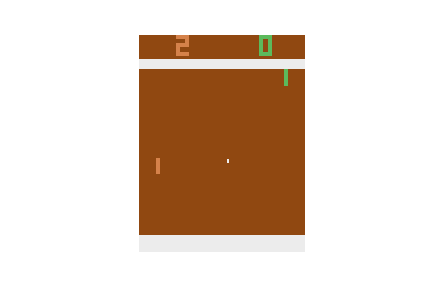
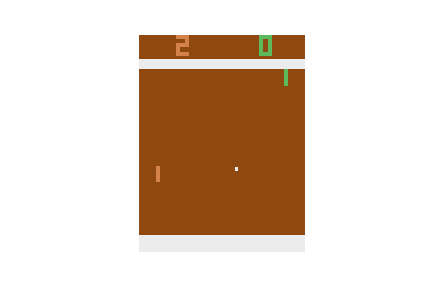
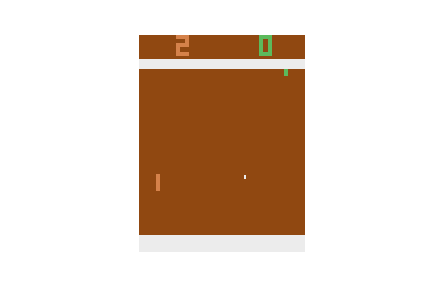
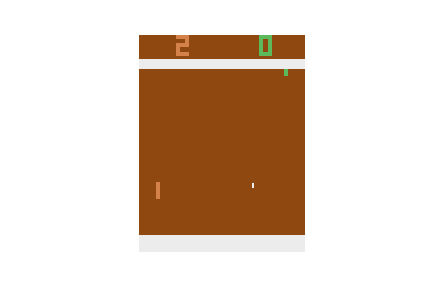
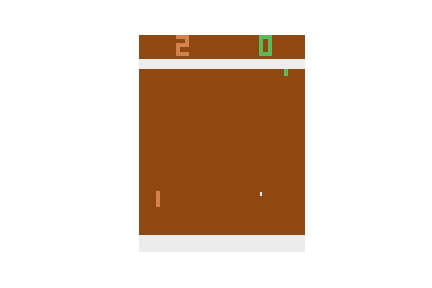
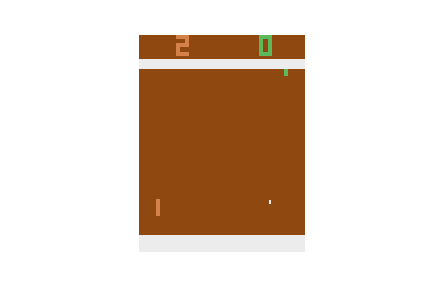
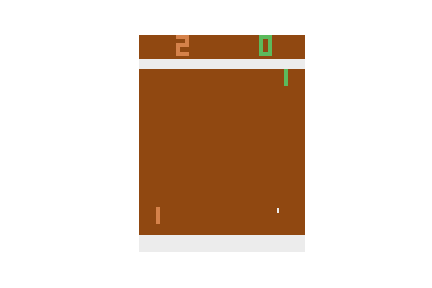
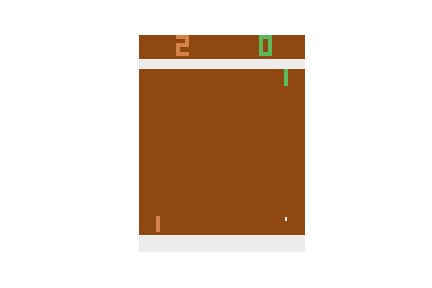
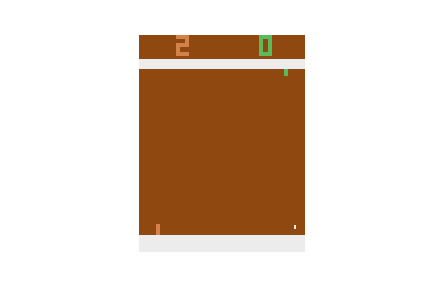
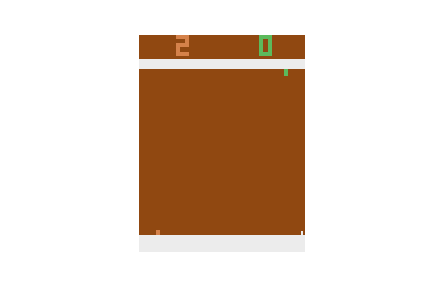
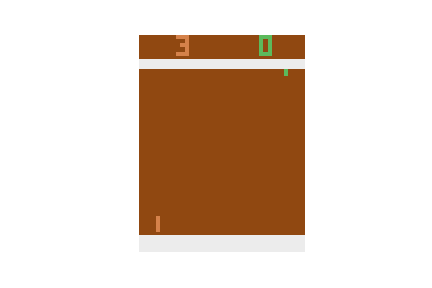
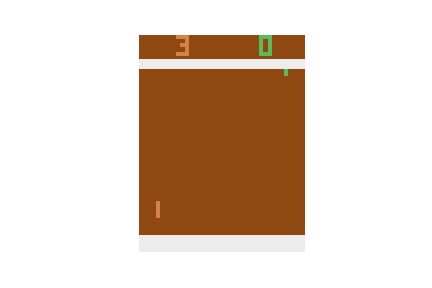
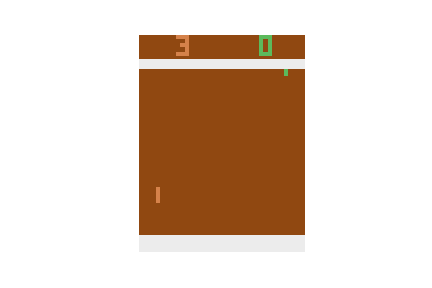
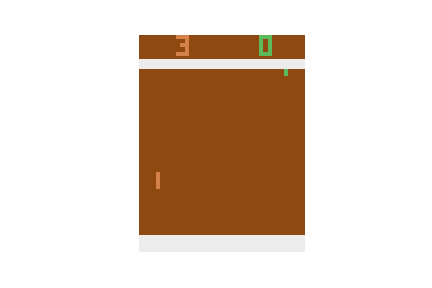
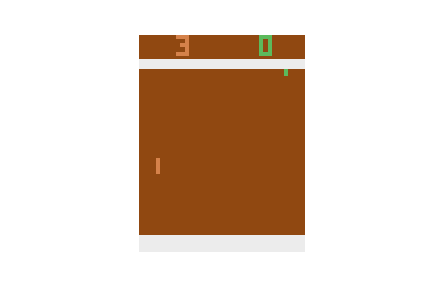
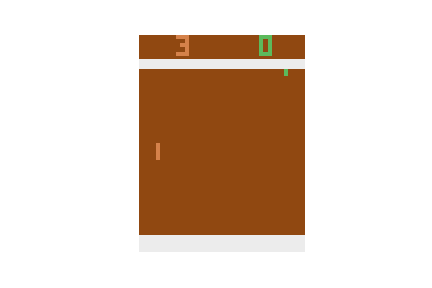
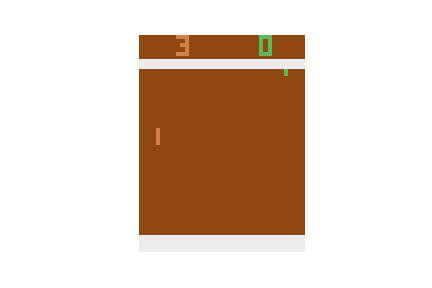
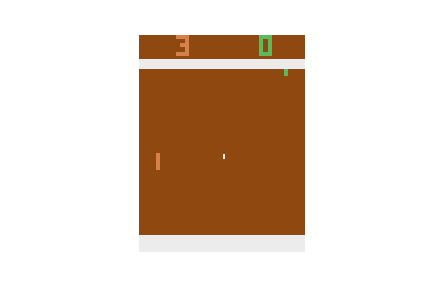
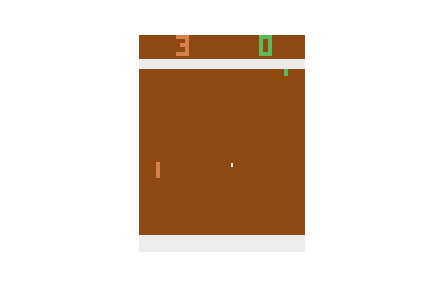
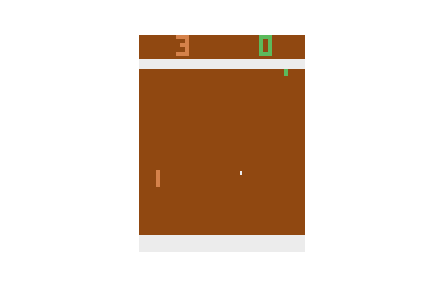
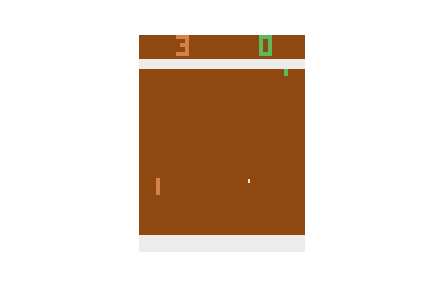
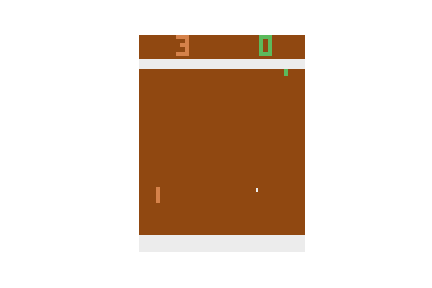
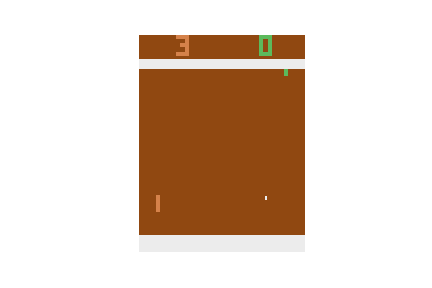
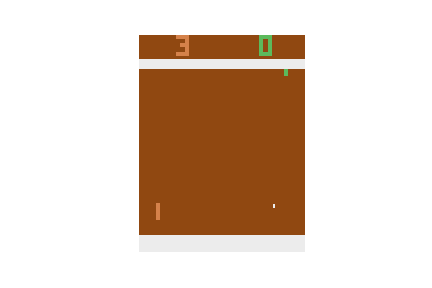
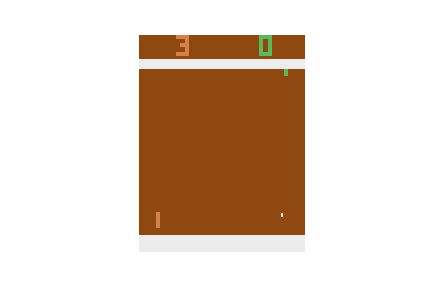
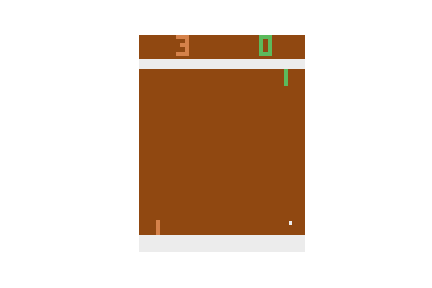
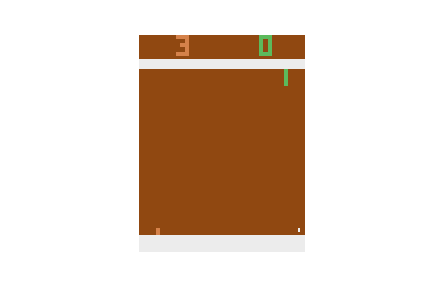
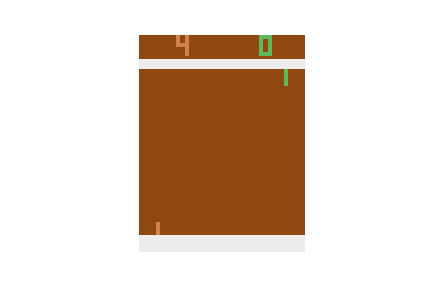
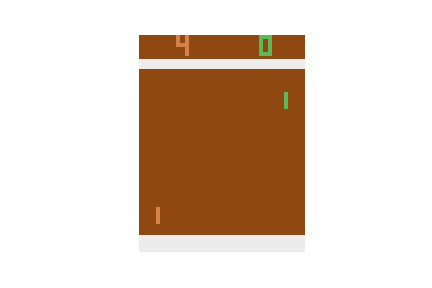
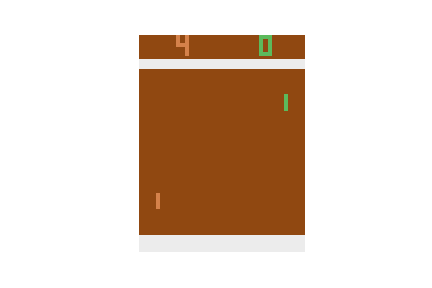
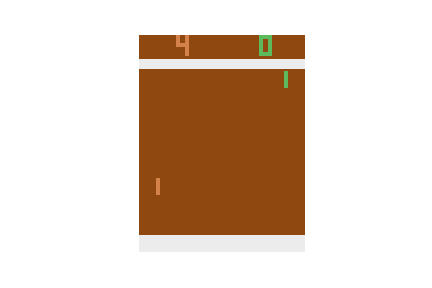
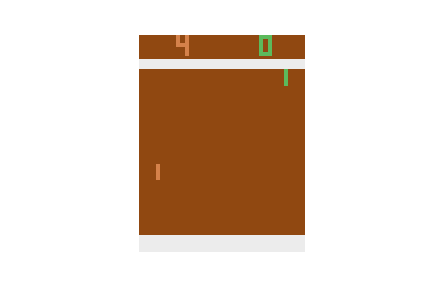
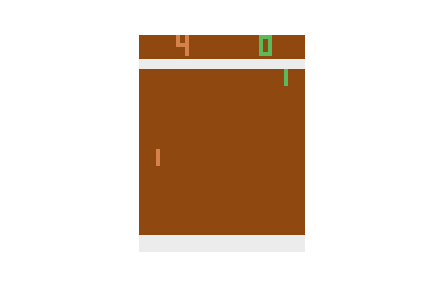
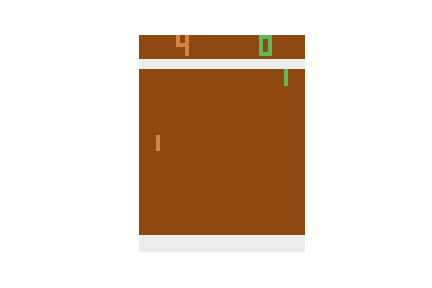
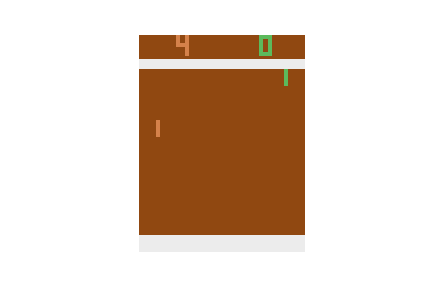
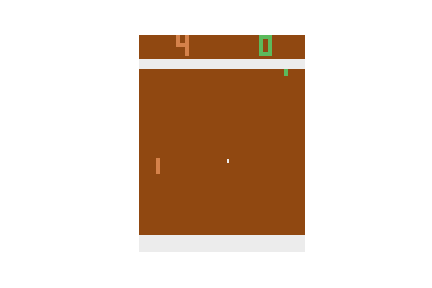
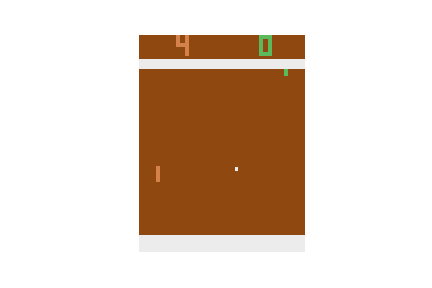
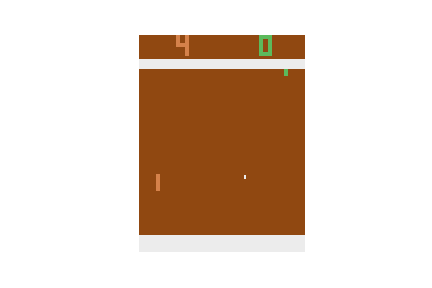
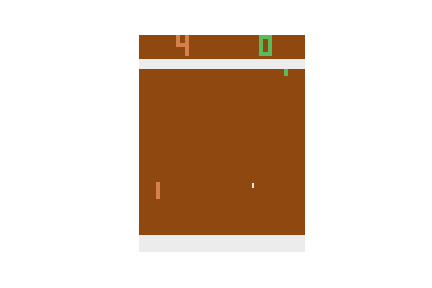
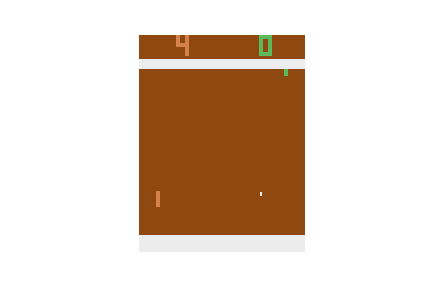
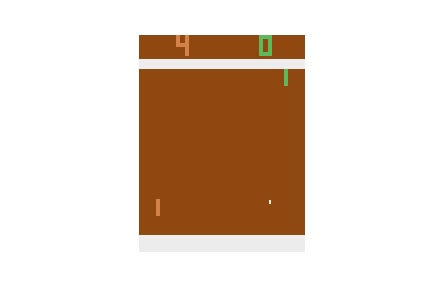
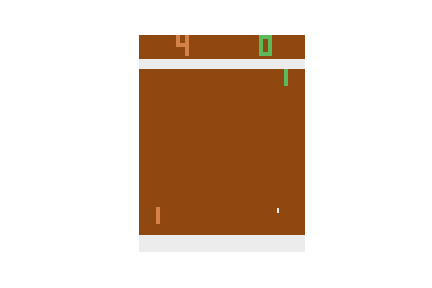
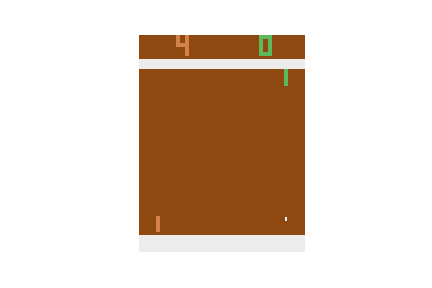
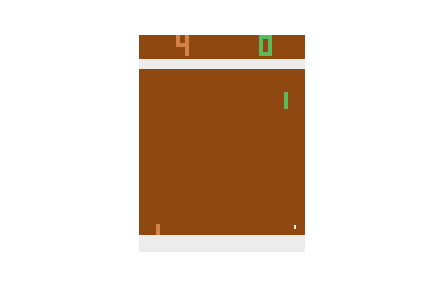
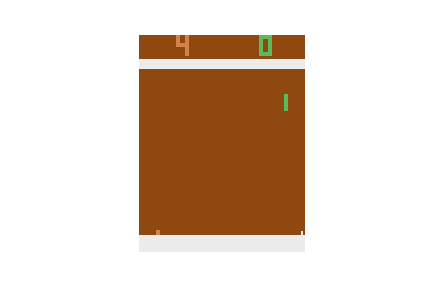
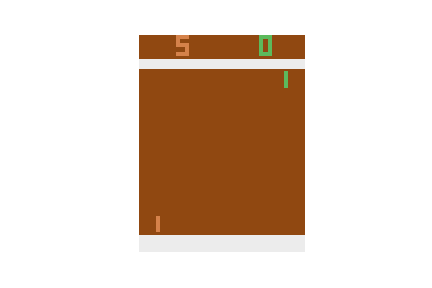
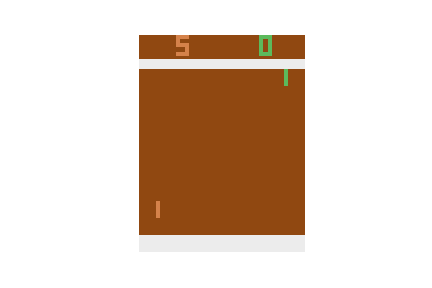
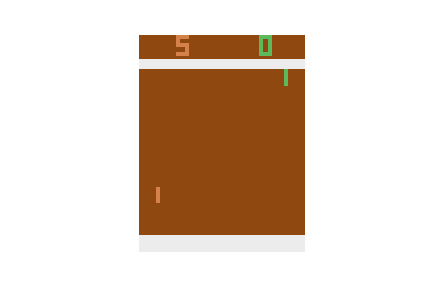

In [17]:
pong_utils.play(env, policy, time=100)

# Rollout 
Before we start the training, we need to collect samples. To make things efficient we use parallelized environments to collect multiple examples at once

In [31]:
env = pong_utils.parallelEnv('PongDeterministic-v4', n=4, seed=12345)
prob, state, action, reward = pong_utils.collect_trajectories(env,policy,tmax=100)

In [49]:
reward_array = np.asarray(reward)
discount_array = 0.995**np.arange(reward_array.shape[0]).reshape(-1,1)

In [59]:
d_r = reward_array*discount_array
future_reward = d_r[::-1].cumsum(0)[::-1]

# Function Definitions
Here we will define key functions for training,

## Exercise 2: write your own function for training
(this same as policy as ploicy_loss except the negative sign)

## REINFORCE

you have two choices(usually it's useful to divide by the time since we've normalized our reward and the time of each trajectory is fixed)
1. $\frac{1}{T}\sum^{T}_{t} R^{future}_{t}\log(\pi_{\theta^{'}}(a_t|s_t))$
2. $\frac{1}{T}\sum^{T}_{t} R^{future}_{t} \frac{\pi_{\theta^{'}}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)}$ where $\theta^{'}=\theta$ and make sure that the `no_grad` is enabled when performing the division

In [61]:
def surrogate(policy, old_probs, states, actions, rewards,discount=0.995,
             beta=0.01):
    RIGHT = 4 ## 'RIGHTFIRE'
    LEFT = 5  ## 'LEFTFIRE'
    ## making reward as a array so can do vectorized operations
    reward_array = np.asarray(rewards)
    ## creating a discounting array and reshaping it to have a dimension
    ## along column (vectorizing purpose)
    discount_array = discount**np.arange(reward_array.shape[0]).reshape(-1,1)
    ## d_r is discounted reward along the horizon
    d_r = reward_array*discount_array
    ## calculating future reward at each state, important try to understand 
    ## why we are reversing the list before calculating cumulative sum
    ## reversing it again.
    future_reward = d_r[::-1].cumsum(0)[::-1]
    ## calculating mean 'for each state at time = t'
    ## Caution: mean is not calculated along a "Episode"!
    ## reshaping for vectorized purpose
    mean = np.mean(future_reward,axis=1).reshape(-1,1)
    ## calculating std 'for each state at time = t'
    ## Caution: std is not calculated along a "Episode"!
    ## reshaping for vectorized purpose    
    std = np.std(future_reward,axis=1).reshape(-1,1)+1.0e-10
    ## normalized reward
    rewards_normalized = (future_reward-mean)/std
    
    #convert everything into pytorch tensor and move it to gpu if available
    actions = torch.tensor(actions, dtype=torch.int8, device=device)
    old_probs = torch.tensor(old_probs, dtype=torch.float,device=device)
    rewards = torch.tensor(rewards_normalized, dtype=torch.float,
                          device= device)
    
    #convert states to policy (or probability)
    new_probs = states_to_prob(policy,states)
    new_probs = torch.where(actions==RIGHT, new_probs, 1.0-new_probs)
    
    ratio = new_probs/old_probs
    
    #include a regularization term
    # this steers new_policy towards 0.5
    # add in 1e-10 to avoid log(0) which gives nan
    entropy = -(new_probs*torch.log(old_probs+1.0e-10)+ \
             (1.0-new_probs)*torch.log(1.0-old_probs+1.0e-10))
    
    return torch.mean(ratio*rewards + beta*entropy)
    
    
    

## Training 
We are now ready to train our policy! WARNING: make sure to turn on GPU, which also enabels multicore processing. It may take up to 45 minutes even with GPU enabeled, otherwise it will take much longer!

In [ ]:
from parallelEnv import parallelEnv
import numpy as np


# training loop max iterations
episode = 500


#widget bar to display progress
!pip install progressbar
import progessbar as pb
widget = ['training loop: ', pb.Percentage(), ' ',
         pb.Bar(),' ',pb.ETA()]
timer = pb.ProgressBar(widgets = widget, maxval=episode ).start()

#initialize environment
envs1 = parallelEnv('PongDeterministic-v4',n=8,seed=1234)

discount_rate = 0.99
beta = .01
tmax = 320

#keep track of progress
mean_rewards = []

for e in range(episode):
    
    #collect trajectories
    old_probs, states, actions, rewards = \
    pong_utils.collect_trajectories(envs1, policy,tmax=tmax)
    
    total_rewards = np.sum(rewards, axis=0)
    
    L = -surrogate(policy, old_probs, states, actions, rewards, beta=beta)
    
    optimizer.zero_grad()
    L.backward()
    optimizer.step()
    del L
    
    #this regulation term also reduces
    # this reduces exploration in later runs
    beta*=.995
    
    # get the average reward of parallel environments
    mean_rewards.append(np.mean(total_rewards))
    
    #display some progress every 20 iterations
    if (e+1)%20==0:
        print("Episode: {0:d}, score {1:f}".format(e+1, np.mean(total_rewards)))
        
    timer.update(e+1)

timer.finish()
        


In [ ]:
#save our policy!
torch.save(policy, "REINFORCE.policy")

#load our policy if needed
#policy = torch.load("REINFORCE.policy")

## Going through some pong_utlis.py  functions

In [ ]:
## collect trajectories for a parallelized parallelEnv object.
def collect_trajectories(envs, policy, tmax=200, nrand = 5):
    
    #number of parallel instances
    n = len(envs.ps)
    
    #initialize returning lists and start the game!
    state_list = []
    reward_list = []
    prob_list = []
    action_list = []
    
    envs.reset()
    
    #start all parallel agents
    envs.step([1]*n)
    
    #performs nrand random steps
    for _ in range(nrand):
        fr1, re1, _, _ = envs.step(np.random.choice([RIGHT, LEFT],n))
        fr2, re2, _, _ = envs.step([0]*n)
        
    for t in range(tmax):
        
        #prepare the input
        #preprocess_batch properly convert two frames into
        # shape (n, 2, 80, 80) [pytorch convention (batch_size, channel_Width,width, length)],
        # the proper input for the policy this is required when building CNN with pytorch
        
        batch_input = preprocess_batch([fr1,fr2])
        
        
        # probs will only be used as the pi_old
        # no gradient propagation is needed
        # so we move it to the cpu
        probs = policy(batch_input).squeeze().cpu().detach().numpy()
        
        action = np.where(np.random.rand(n)<probs, RIGHT,LEFT)
        probs = np.where(action==RIGHT, probs, 1.0-probs)
        ## our policy has only one output node which predict the probability
        ## of going right(RIGHTFIRE) and prob of LEFTFIRE (1-prob)
        
        #advance the game (0=no action)
        # we take one action and skip the game forward
        fr1, re1, is_done, _ = envs.step(action)
        fr2, re2, is_done, _ =envs.step([0]*n)
        ## all the variable above are lists across all the possible 
        ## trajectory(paralllel Env)
        
        reward = re1+re2
        
        #store the result
        state_list.append(batch_input)
        reward_list.append(reward)
        prob_list.append(probs)
        action_list.append(action)
        
        #stop if any of the trajectories is done
        # we want all the lists to be rectangular
        if is_done.any():
            break
    
    #return pi_theta, states, actions, rewards, probability
    return prob_list, state_list, action_list, reward_list

# Importance Sampling

## 1. Policy Update in REINFORCE
Let's go back to the REINFORCE algorithm. We can start with a policy, $\pi_{\theta}$, then using that policy, we can generate a trajectory (or multiple ones to reduce noise)($s_t,a_t,r_t$). Afterward, we compute a policy gradient, g, and update $\theta^{'}\gets \theta + \alpha g$.


At this point, the trajectories we've just generated are simply thrown away. If we want to update our policy again, we would generate __new trajectories once more, using the updated policy__.


We might ask, why is all this necessary? It's because we need to compute the __gradient for the current policy__, and to do that the trajectories need to be representative of the current policy.

But it sounds a little wasteful. What if we could somehow recycle the old trajectories, by modifying them so that they are representative of the new policy? So that instead of just throwing them away, we **Recycle them**!


Then we could just reuse the recycled trajectories to compute gradients, and to update our policy, again, again. This would make updating the policy a lot more efficient. **So, how exactly would that work?**


## 2. Importance Sampling
This is where importance sampling comes in. Let's look at the trajectories we generated using the policy $\pi_{\theta}$. It had a proabability $P(\tau;\theta)$, to be sampled.

Now just by chance, the same trajectory can be sampled under the new policy, with a different probability $P(\tau;\theta^{'})$

__Imagine we want to compute the average of some quantity, say $f(\tau)$. We could simply generate ALL trajectorues from the new policy, compute $f(\tau)$ and average them.__

Mathematically, this is equivalent to adding up all the $f(\tau)$, weighted by a probability of sampling each trajectories under the new policy.


$\sum_{\tau}P(\tau;\theta^{'})f(\tau)$

Now we could modify this equation, by multiplying and dividing by the same number, $P(\tau;\theta)$ and rearrange the terms.


$\sum_{\tau} P(\tau;\theta) \frac{P(\tau;\theta^{'})}{P(\tau;\theta)} f(\tau)$

It doesn't look we've done much. But written in this way, we can reinterpret the first part as the coefficient for sampling under the old policy, with an extra re-weighting factor, in addition to just averaging.

Intutively, this tells us we can use old trajectories for computing averages for new policy, __as long as we add this extra re-weighting factor, that takes into account how under or over-represented each trajectory is under the new policy compared to the old one.__

The same trick are used frequently across statistics, where the re-weighting factor is included to un-bias surveys and voting predicitions.

## 3. The re-weighting factor
Now let's a closer look at the re-weighting factor.


Because each trajectory contains many steps, the proabaility contains a chain of products of each policy at different time-step.

This formula is a bit complicated. But there is a bigger problem. When some of policy gets close to zero, the re-weighting factor can become close to zero ,or worse, close to 1 over 0 which diverges to infinity.

When this happens the re-weighting trick becomes unreliable. So in practice we want to makes sure the re-weighting factor is **not too far** from 1 when we utilze importance sampling.

# PPO Part 1: The surrograte Function
Suppose we are trying to update our current policy, $\pi_{\theta^{'}}$. To do that, we need to estimate a gradient, g.__But we only have trajectories generated by an older policy $\pi_\theta$__.How do we compute the gradient then?

Mathematically, we could utilize importance sampling. The answer just what a normal policy gradient would be, times a re-weighting factor $\frac{P(\tau;\theta^{'})}{P(\tau;\theta)}$:

> $$g = \frac{P(\tau;\theta^{'})}{P(\tau;\theta)}\sum_{t}\frac{\delta_{\theta^{'}}\pi_\theta^{'}(a_t|s_t)}{\pi_\theta^{'}(a_t|s_t)}R_t^{future}$$


We can rearrange these equations, and the re-weighting factor is just the product of all the policy across each step -- I've picked out the terms at time-step t here. We can cancel some terms, but we're still left with a product of the policies at different times, denoted by "...".

>$g = \sum_t \frac{...\pi_{\theta^{'}}(a_t|s_t)...}{...\pi_{\theta}(a_t|s_t)...} \frac{\delta_\theta^{'} \pi_{\theta^{'}}(a_t|s_t)}{\pi_{\theta^{'}}(a_t|s_t)}R_t^{future}$

Can we simplify this expression further? This is where proximal policy comes in. If the old and current policy is close enough to each other, all the factors inside the "..." would be pretty close to 1, and then we can ignore them.

Then the equation simplifies
>$$g = \sum_{t}\frac{\delta_{\theta^{'}}\pi_{\theta^{'}}(a_t|s_t)}{\pi_\theta(a_t|s_t)}R_t^{future}$$


It looks very similar to the old policy gradient. In fact, if the current policy and the old policy is the same, we would have exactly the vanilla policy gradient. But remember, this expression is different we are comparing two different policies


## The Surrogate Function
Now that we have the approximated from the gradient, we can think of it as the gradient of a new object, called the surrogate function
>$g = \delta_{\theta^{'}}L_{sur}(\theta^{'},\theta)$
<br>$L_{sur}(\theta^{'},\theta)= \sum_{t}\frac{\delta_{\theta^{'}}(a_t|s_t)}{\pi_\theta(a_t|s_t)}R_t^{future}$


So using the new gradientm we can perform gradient ascent to update our policy -- which can be thought as directly maximize the surrogate function.

But there is still one important issue we haven't addressed yet. If we keep resuing old trajectories and updating our policy, at some point the new policy mught become different enough from old one, so that all the approximations we made could become invalid.

## PPO Part 2: Clipping Policy Updates

### The Policy/Reward Cliff
What is the problem with updating our policy and ignoring the fact that the approximations are not valid anymore? One problem is it could lead to a really bad policy that is very hard to recover from. Let's see how:

<img src = "a16.PNG">

Say we have some policy paratererized by $\pi_{\theta^{'}}$ and with an average reward function.

The current policy is labelled by the red text,and the goal is to update the current policy to the optimal one (green star). To update the policy we can compute a surrogate function $L_{sur}$(dotted curve on right plot). So $L_{sur}$ approximates the reward pretty well around the current policy. But far away from the current policy, it diverges from actual reward.

If we continually update the policy by performing gradient ascent, we might get something like the red-dots. The big problem is that at some point we hit a cliff, where the policy changes by a large amount. From the perspective of the surrogate function, the average reward is really great. But actually average reward is really bad!

What's worse, the policy is now stuck in a deep and flat bottom, so that future updates won't be able to bring the policy back up! we are now stuck with a really bad policy.

How do we fix this? Wouldn't it be great if we can somehow stop the gradient ascent so that our policy dosen't fall off the cliff?


## Clipped Surrogate Function
<img src ="a17.png">
Here's an idea: what if we just flatten the surrogate function (blue curve)? What would policy update look like then?

So starting with the current policy (blue dot_, we apply gradient ascent. The updates remain the same, until we hit the flat plateau. Now because the reward function is __flat__, the gradient is zero, and the policy update will stop!

Now, keep in mind that we are only showing a 2D figure with one $\theta^{'}$ direction. In most cases, there are thousands of parameters in a policy, and there may be hundreds/thousands of high-dimensional cliffs in many different directions. We need to apply this clipping mathematically so that it will automatically take care of all the cliffs. 


## Clipped Surrogat Function
Here's the formula that will automatically flatten our surrogate to avoid all the cliffs:
$$L^{clip}_{sur}(\theta^{'},\theta) = \sum_{t}min\{\frac{\pi_{\theta^{'}}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)}R_t^{future},cilp_{\epsilon}(\frac{\pi_{\theta^{'}}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)}R_t^{future})\}$$

Now let's dissect the formula by looking at one specific term in the sum, and set the future reward to 1 to make things easier.

<img src = "a18.png">

We start with the original surrogate function (Red), which involves the ratio $$\pi_{\theta^{'}(a_t|s_t)/\pi_{\theta}(a_t|s_t)}$$. The black dot shows the location where the current policy is the same as the policy old ($\theta^{'}=\theta$ )


We want to make sure the the tow policy is similar, or that the ratio is close to 1. So we choose a small $\epsilon$(typically 0.1 or 0.2), and apply the clip function to force the ration be within the interval $[1-\epsilon, 1+\epsilon]$

Now the ratio is clipped in two places. But we only want to clip the top part and not the bottom part. To do that, we compare this clipped ratio to the original one and take the minimum (show in blue). This then ensures the clipped surrogate function $$L_{sur}^{clip} \ge L_{sur}$$, so the clipped surrogate function gives a more conservative "reward".

# BIG PICTURE OF PPO
**WE WILL CLIP THE SURROGATE FUNCTION TO ENSURE THAT THE NEW POLICY REMAINS CLOSE TO THE OLD ONE.**

# PPO Summary

1. Collect trajectories based on $\pi_\theta$, initialize $\theta^{'}=\theta$
2. Compute thr gradient $\delta_{\theta^{'}L_{sur}^{clip}(\theta^{'},\theta)}$
3. Update $\theta^{'} \gets \theta^{'} + \alpha \delta_{\theta^{'}}L_{sur}^{clip}(\theta^{'},\theta)$
4. Repeat step 2 and 3 a couple times
5. Set $\theta = \theta^{'}$, repeat from step 1

## Additional Notes
* Try normalizing our future rewards over all the parallel agents, it can speed up training 
* Simpler network might perform better than more complicated ones! The original input contains $80\times80\times2 = 12800$ numbers, we might wanr to ensure that this number decreases at each layer of the neural net.
* Training performance may be significant worse on local machines. I had worse performance training on my own .... This may be due to slightly different ways the emulator is rendered. So please run the code on the workspace first before moving locally
* It may be beneficial to train multiple epochs, say first using small t_max=200 with 500 episodes, and then train agent with t_max=400 with 500 episodes, and then finally with a larger t_max
* Remember to save your policy after traininig!
* for a challange, try the `Pong-v4` environment, this includes random frameskips and takes longer to train.

# PPO Implementation

## Policy 

## Exercise 1: Implement our Policy

Here, we define our policy. The input is stack of two different frames (which captures the movement), and the output is a number $P_{left} = 1 - P_{right}$


In [ ]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# def get_cov_outdim(in_size,k_size,stride,padding=0):
#         return (in_size-k_size+2*padding)//stride +1
# def get_cov_outdim(in_size,k_size,stride,padding=0):
#         out = (in_size-k_size+2*padding)//stride +1
#         print(out)
#         return out

#set up a convolution neural network
# the output is the probability of moving right
class Policy(nn.Module):
    
    def __init__(self):
        super().__init__()
        ## input_size of the image is (80x80)
        self.conv1 = nn.Conv2d(2,32,kernel_size=4,stride=2)
        out_dim = self.get_cov_outdim(80,4,2)
        self.conv2 = nn.Conv2d(32,64,kernel_size=4,stride=2)
        out_dim = self.get_cov_outdim(out_dim,4,2)
        self.conv3 = nn.Conv2d(64,128,kernel_size=4,stride=4)
        out_dim  = self.get_cov_outdim(out_dim,4,4)
        self.size  = out_dim*out_dim*128
        
        ## 2 fully connected layer
        self.fc1 = nn.Linear(self.size,16)
        self.fc2 = nn.Linear(16,1)
        self.sig = nn.Sigmoid()
        
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc1(x.view(-1,self.size)))
        return self.sig(self.fc2(x))
    
    def get_cov_outdim(self,in_size,k_sizes,stride,padding=0):
        out = (in_size-k_sizes+(2*padding))//stride +1
#         print(out)
        return out
    
    
policy = Policy().to(device)
# we use the adam optimizer with learning rate 2e-4
# optim.SGD is also possible
import torch.optim as optim
optimizer = optim.Adam(policy.parameters(), lr = 1e-4)

# Function Definitions
Here we will define key functions for training.

## Exercise 2:  write our own function for training

## PPO
Later on, we'll implement the PPO algorithm as well, and the scalar function is given by 
$$L^{clip}_{sur}(\theta^{'},\theta) = \sum_{t}min \left \{\frac{\pi_{\theta^{'}}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)}R_t^{future},cilp_{\epsilon}(\frac{\pi_{\theta^{'}}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)}R_t^{future})\right\}$$

the $clip_{\epsilon}$ function is implemented in pytorch as `torch.clamp(ratio, 1-epsilon,1+epsilon)`

In [10]:
import numpy as np

In [ ]:
def clipped_surrogate(policy, old_probs, states, actions, rewards, 
                     discount = 0.995, epsilon=0.1, beta=0.01):
    reward_array = np.asarray(rewards)
    
    ## creating a discounting factor
    discounting_factor = discount**np.arange(reward_array.shape[0]).reshape(-1,1)
    
    ## discounted_reward 
    discounted_reward = discounting_factor*reward_array
    
    ## calculating the future reward
    future_reward = discounted_reward[::-1].cumsum(0)[::-1]
    
    ## mean for normalizing reward
    mean  = np.mean(discounted_reward,axis=1).reshape(-1,1)
    
    ## std for normalizing reward
    std = np.std(discounted_reward,axis=1).reshape(-1,1)+ 1e-10
    
    
    ## Normalizing the reward 
    normalized_reward = (future_reward-mean)/std
    ##Converting the variable to tensor
    
    reward_tensor = torch.tensor(normalized_reward,dtype=torch.float,
                                device=device)
    
    old_probs = torch.tensor(old_probs, dtype=torch.float,
                             device=device)
    actions =torch.tensor(actions, dtype = torch.int8, device=device)
    
    ## convert state to policy (or probability)
    new_probs = pong_utils.states_to_prob(policy,states)
    new_probs = torch.where(actions==pong_utils.RIGHT, new_probs,1-new_probs)
    
    
    ratio = new_probs/old_probs
    
    ## clipped ratio
    clipped_Ratio =torch.min(ratio,torch.clamp(ratio,1-epsilon,1+epsilon)*ratio)
    
    # include a regularization term
    # this steers new_policy towards 0.5
    # prevents policy to become exactly 0 or 1 helps exploration
    # add in 1.0e-10 to avoid log(0) which gives nan
    
    entropy = -(new_probs*torch.log(old_probs+1.e-10)+ \
        (1.0-new_probs)*torch.log(1.0-old_probs+1.e-10))
    
    return torch.mean(beta*entropy + reward_tensor*clipped_Ratio)
    
    

## Training
Implementation of PPO algorithm

In [ ]:
from parallelEnv import parallelEnv
import numpy as np


#training loop max_iterations
epsiodes = 500

#widget bar for progressbar
import progressbar as pb
widget = ['training loop: ', pb.Percentage(), ' ', 
          pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episode).start()


envs = parallelEnv('PongDeterministice-v4', n=8, seed=1234)

discount_rate = .99
epsilon = 0.1
beta = .01
beta = 320
tmax = 320
SGD_epoch = 4

## keep track of the progress 
mean_rewards = []

for e in range(epsiodes):
    
    ## collect trajectories
    old_probs, states, actions, rewards = \
        pong_utils.collect_trajectories(envs, policy, tmax=tmax)
    
    total_rewards = np.sum(rewards,axis=0)
    
    
    # gradient ascent step
    for _ in range(SGD_epoch):
        
        #uncomment to utilize our own clipped function!
        L = - clipped_surrogate(policy, old_probs, states,
                               actions, rewards, epsilon=epsilon,
                               beta = beta)
        
        optimizer.zero_grad()
        L.backward()
        optimizer.step()
        del L
        
    ## the clipping parameter reduces as time goes on
    epsilon *= .999
    
    # the regularization term also reduces
    # this reduces exploration in later runs
    beta*=.995
    # get the average reward of the parallel environments
    mean_rewards.append(np.mean(total_rewards))
    
    # display some progress every 20 iterations
    if (e+1)%20 ==0 :
        print("Episode: {0:d}, score: {1:f}".format(e+1,np.mean(total_rewards)))
        print(total_rewards)
        
    # update progress widget bar
    timer.update(e+1)
    
timer.finish()

In [ ]:
# save your policy!
torch.save(policy, 'PPO.policy')

# load policy if needed
# policy = torch.load('PPO.policy')

# try and test out the solution 
# make sure GPU is enabled, otherwise loading will fail
# (the PPO verion can win more often than not)!
#
# policy_solution = torch.load('PPO_solution.policy')
# pong_utils.play(env, policy_solution, time=2000) 